In [1]:
import utils
from os import path
import cv2
import numpy as np
from os import path, listdir
import matplotlib.pyplot as plt
import gaze_heatmap as gh

Using TensorFlow backend.


In [2]:
env_name = 'breakout'
trial_name = '519_AS_4083721_Jul-25-14-44-15'
trial_name_elements = trial_name.split('_')
img_prefix = trial_name_elements[1]+'_'+trial_name_elements[2]+'_'

# TODO: randomly sample 10 images from trial
start_img_idx = 5000
data_dir = '/home/akanksha/learning-rewards-of-learners/data/novice-atari-head/'
traj_dir = path.join(path.join(data_dir, env_name),trial_name)

#load data
if env_name in ['mspacman', 'centipede', 'asterix', 'berzerk', 'hero', 'enduro']:
    crop_top = False  # mask out few rows from the bottom
else:
    crop_top = True

In [3]:
def MaxSkipAndWarpFrames(traj_dir, start_img_idx):
    """take a trajectory file of frames and max over every 3rd and 4th observation"""
    skip = 4  
    sample_pic = np.random.choice(
        listdir(path.join(traj_dir)))
    image_path = path.join(traj_dir, sample_pic)
    print(image_path)
    pic = cv2.imread(image_path)
    obs_buffer = np.zeros((2,)+pic.shape, dtype=np.uint8)
    print(obs_buffer.shape)
    max_frames = []
    for i in range(16):
        img_name = traj_dir+'/'+img_prefix+str(start_img_idx+i)+'.png' 
#         print(img_name)

        if i % skip == skip - 2:
            obs = cv2.imread(img_name)
            print(img_name)
#             print(obs)
            
            obs_buffer[0] = obs
        if i % skip == skip - 1:
            obs = cv2.imread(img_name)
            obs_buffer[1] = obs

            # warp max to 80x80 grayscale
            image = obs_buffer.max(axis=0)
            warped = utils.GrayScaleWarpImage(image)
            max_frames.append(warped)
#     print('frames: ', len(max_frames))
    return max_frames


def StackFrames(frames):
    import copy
    """stack every four frames to make an observation (84,84,4)"""
    stacked = []
    stacked_obs = np.zeros((84, 84, 4))
    for i in range(len(frames)):
        if i >= 3:
            stacked_obs[:, :, 0] = frames[i-3]
            stacked_obs[:, :, 1] = frames[i-2]
            stacked_obs[:, :, 2] = frames[i-1]
            stacked_obs[:, :, 3] = frames[i]
            stacked.append(np.expand_dims(copy.deepcopy(stacked_obs), 0))
    print('stacked frames: ', len(stacked))
    return stacked


In [4]:
### image stack --> GT gaze

#load 16 consecutive images starting from start_img_idx
imgs = []
for i in range(16):
    img = cv2.imread(traj_dir+'/'+img_prefix+str(start_img_idx+i)+'.png')
    imgs.append(img)

# Skip, Mask, Stack Images
print(start_img_idx, traj_dir)
maxed_traj = MaxSkipAndWarpFrames(traj_dir, start_img_idx)
stacked_traj = StackFrames(maxed_traj)
masked = utils.mask_score(utils.normalize_state(stacked_traj[0]), env_name, crop_top)


5000 /home/akanksha/learning-rewards-of-learners/data/novice-atari-head/breakout/519_AS_4083721_Jul-25-14-44-15
/home/akanksha/learning-rewards-of-learners/data/novice-atari-head/breakout/519_AS_4083721_Jul-25-14-44-15/AS_4083721_7187.png
(2, 210, 160, 3)
/home/akanksha/learning-rewards-of-learners/data/novice-atari-head/breakout/519_AS_4083721_Jul-25-14-44-15/AS_4083721_5002.png
/home/akanksha/learning-rewards-of-learners/data/novice-atari-head/breakout/519_AS_4083721_Jul-25-14-44-15/AS_4083721_5006.png
/home/akanksha/learning-rewards-of-learners/data/novice-atari-head/breakout/519_AS_4083721_Jul-25-14-44-15/AS_4083721_5010.png
/home/akanksha/learning-rewards-of-learners/data/novice-atari-head/breakout/519_AS_4083721_Jul-25-14-44-15/AS_4083721_5014.png
stacked frames:  1


In [5]:
fig = plt.figure(figsize=(15,15))
c=0
# first line is the metadata, second is the header
# indices of frames in the stack 
k = range(start_img_idx, start_img_idx+16, 4) # every 4th frame
k1 = range(start_img_idx, start_img_idx+16) # 16 consecutive frames
gaze = []
conv_size = 20
height, width = imgs[0].shape[0], imgs[0].shape[1]
gt_gaze = np.zeros((height,width,3))
last_img = imgs[15]

## load corresponding GT gaze using asc and text file
# raw gaze coord circles on image
with open(traj_dir+'.txt') as f:
    for i, line in enumerate(f):
        if i in k1: #coz 1st line in text file is metadata
            #frame,reward,score,terminal, action
            curr_data = line.rstrip('\n').split(',')
            gaze_coords = [float(gp) if gp != 'null' else float('nan') for gp in curr_data[6:]]
            gaze.append(gaze_coords)
            
            if i in k:
                c+=1
                # overlay gaze coordinates on img
                img_full = imgs[c*4-1]
                #  normalized image to scaled and converted to uint8 for image processing
                img = 255*masked[:,:,:,c-1].squeeze()
                img = img.astype(np.uint8)

                h, w = img.shape[0], img.shape[1]

                for j in range(0,len(gaze_coords),2):
    #                 if('null' not in gaze_coords[j]):
                    x = float(gaze_coords[j])
                    y = float(gaze_coords[j+1])
                    x_norm, y_norm = x/width, y/height
                    x1, y1 = int(x_norm*w), int(y_norm*h)
                    cv2.circle(img, (x1,y1), 3, (255,255,255), thickness=1, lineType=8)
                    cv2.circle(img_full, (int(x),int(y)), 3, (255,255,255), thickness=1, lineType=8)
                    cv2.circle(gt_gaze, (int(x),int(y)), 3, (255,255,255), thickness=1, lineType=8)
                    cv2.circle(last_img, (int(x),int(y)), 3, (255,255,255), thickness=1, lineType=8)

<Figure size 1080x1080 with 0 Axes>

In [6]:
# image stack, trained BCO model 
import cnn
import torch
torch.cuda.empty_cache()
torch.device('cuda:0')

#TODO: get model name from params
model_path = '/home/akanksha/Documents/behavioral_cloning_atari/checkpoints_dropout_novices/breakout/breakout_dropout_network.pth.tar'
model = cnn.Network(num_output_actions=4)
chkpt = torch.load(model_path, map_location='cpu')
model.load_state_dict(chkpt['state_dict'])

# # plot heatmap
mask_size = 3
print(masked.shape)
# img_stack = masked.clone()

(1, 84, 84, 4)


torch.Size([1, 32, 20, 20]) torch.Size([1, 64, 9, 9]) torch.Size([1, 64, 7, 7])
gaze_coords length:  16
16 <class 'numpy.ndarray'>
(20, 20, 1)
gaze frames:  4
stacked gaze frames:  1
gaze_coords length:  16
16 <class 'numpy.ndarray'>
(9, 9, 1)
gaze frames:  4
stacked gaze frames:  1
gaze_coords length:  16
16 <class 'numpy.ndarray'>
(7, 7, 1)
gaze frames:  4
stacked gaze frames:  1


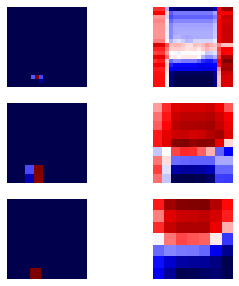

In [9]:
# image stack, trained BCO model --> n conv_layer activations 
# some code already exists in trex repo
import torch
device = torch.device("cpu")
input_stack = torch.from_numpy(masked)
input_stack = input_stack.view(-1,4,84,84)
conv1,conv2,conv3,_,out_actions = model(input_stack.float().to(device))
print(conv1.shape, conv2.shape, conv3.shape)

fig = plt.figure(figsize=(10,5))
h = gh.DatasetWithHeatmap()

#20x20
conv_size = 20
g = h.createGazeHeatmap(gaze, conv_size)
maxed_gaze = utils.MaxSkipGaze(g, conv_size)               
stacked_gaze_20 = utils.CollapseGaze(maxed_gaze, conv_size)
ax3 = fig.add_subplot(3,4,1)
ax3.imshow(stacked_gaze_20[0].squeeze()*255, cmap='seismic')
ax3.set_axis_off()
# ax3.title.set_text('Gaze from txt')

# normalize and collapse conv1 map
conv_gaze = conv1.sum(dim=1)
batch_size = conv1.shape[0]
min_x = torch.min(torch.min(conv_gaze, dim=1)[0], dim=1)[0]
max_x = torch.max(torch.max(conv_gaze, dim=1)[0], dim=1)[0]

min_x = min_x.reshape(batch_size, 1).repeat(
    1, conv_size).unsqueeze(-1).expand(batch_size, conv_size, conv_size)
max_x = max_x.reshape(batch_size, 1).repeat(
    1, conv_size).unsqueeze(-1).expand(batch_size, conv_size, conv_size)
x_norm_20 = (conv_gaze - min_x)/(max_x - min_x)
x_norm_20 = x_norm_20.data.numpy()
ax3 = fig.add_subplot(3,4,2)
ax3.imshow(x_norm_20.squeeze()*255, cmap='seismic')
ax3.set_axis_off()

#9x9
conv_size = 9
g = h.createGazeHeatmap(gaze, conv_size)
maxed_gaze = utils.MaxSkipGaze(g, conv_size)               
stacked_gaze_9 = utils.CollapseGaze(maxed_gaze, conv_size)
ax3 = fig.add_subplot(3,4,5)
ax3.imshow(stacked_gaze_9[0].squeeze()*255, cmap='seismic')
ax3.set_axis_off()

# normalize and collapse conv2 map
conv_gaze = conv2.sum(dim=1)
batch_size = conv2.shape[0]
min_x = torch.min(torch.min(conv_gaze, dim=1)[0], dim=1)[0]
max_x = torch.max(torch.max(conv_gaze, dim=1)[0], dim=1)[0]

min_x = min_x.reshape(batch_size, 1).repeat(
    1, conv_size).unsqueeze(-1).expand(batch_size, conv_size, conv_size)
max_x = max_x.reshape(batch_size, 1).repeat(
    1, conv_size).unsqueeze(-1).expand(batch_size, conv_size, conv_size)
x_norm_9 = (conv_gaze - min_x)/(max_x - min_x)
x_norm_9 = x_norm_9.data.numpy()
ax3 = fig.add_subplot(3,4,6)
ax3.imshow(x_norm_9.squeeze()*255, cmap='seismic')
ax3.set_axis_off()

#7x7
conv_size = 7
g = h.createGazeHeatmap(gaze, conv_size)
maxed_gaze = utils.MaxSkipGaze(g, conv_size)               
stacked_gaze_7 = utils.CollapseGaze(maxed_gaze, conv_size)
ax3 = fig.add_subplot(3,4,9)
ax3.imshow(stacked_gaze_7[0].squeeze()*255, cmap='seismic')
ax3.set_axis_off()

# normalize and collapse conv3 map
conv_gaze = conv3.sum(dim=1)
batch_size = conv3.shape[0]
min_x = torch.min(torch.min(conv_gaze, dim=1)[0], dim=1)[0]
max_x = torch.max(torch.max(conv_gaze, dim=1)[0], dim=1)[0]

min_x = min_x.reshape(batch_size, 1).repeat(
    1, conv_size).unsqueeze(-1).expand(batch_size, conv_size, conv_size)
max_x = max_x.reshape(batch_size, 1).repeat(
    1, conv_size).unsqueeze(-1).expand(batch_size, conv_size, conv_size)
x_norm_7 = (conv_gaze - min_x)/(max_x - min_x)
x_norm_7 = x_norm_7.data.numpy()
ax3 = fig.add_subplot(3,4,10)
ax3.imshow(x_norm_7.squeeze()*255, cmap='seismic')
ax3.set_axis_off()

plt.savefig('breakout_dropout_collapsed_conv.png',bbox_inches="tight")

In [13]:
# compute correlations
# 2D GT gaze map and 2D collapsed conv maps
import scipy

# conv 1
gaze_20 = stacked_gaze_20[0].squeeze()
conv_20 = x_norm_20.squeeze()
print(gaze_20.shape, conv_20.shape)
scipy.stats.pearsonr(gaze_20,conv_20)

# conv2

# conv3

(20, 20) (20, 20)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()